In [21]:
# 基础库
import numpy as np
import pandas as pd
import time
import os

# 绘图库
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# 模型库
from sklearn.linear_model import LassoCV, ElasticNetCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
import xgboost as xgb

# 忽略警告
import warnings
warnings.filterwarnings('ignore')


In [3]:
# 读取训练集和测试集
train = pd.read_csv('../data/train_data.csv')
test = pd.read_csv('../data/test_data.csv')

print('The shape of training data:', train.shape)
print('The shape of testing data:', test.shape)


The shape of training data: (1458, 83)
The shape of testing data: (1459, 82)


Skewness of target: 1.8812964895244009
Kurtosis of target: 6.523066888485879


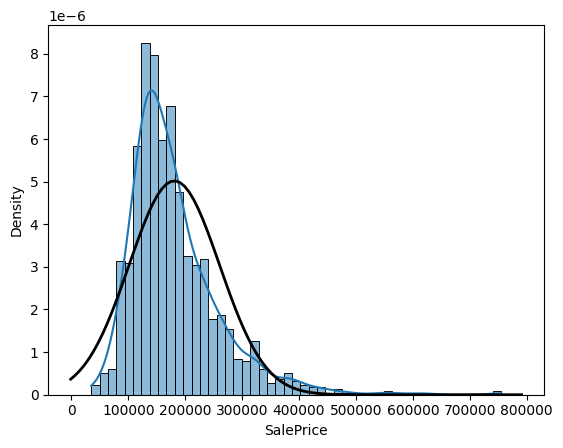

In [8]:
# 查看目标值的斜度和峰度
from scipy.stats import skew, kurtosis, norm

y = train['SalePrice']
print('Skewness of target:', y.skew())
print('Kurtosis of target:', y.kurtosis())

# 绘制直方图并拟合正态分布
sns.histplot(y, kde=True, stat="density")  # 使用 histplot 绘制直方图
xmin, xmax = plt.xlim()  # 获取 x 轴范围
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, y.mean(), y.std())  # 计算正态分布的概率密度函数
plt.plot(x, p, 'k', linewidth=2)  # 绘制正态分布曲线
plt.show()


Skewness of target: 0.12157976050304882
Kurtosis of target: 0.8047507917418972


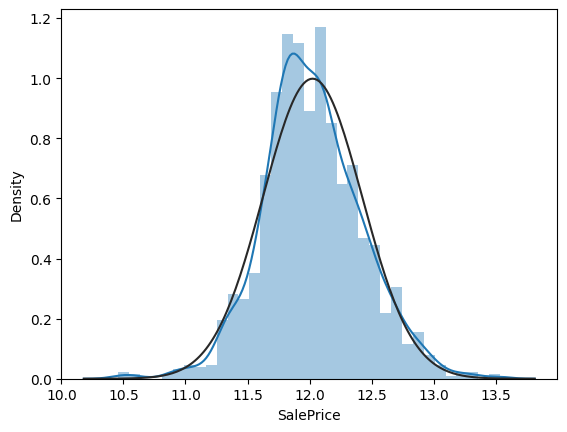

In [9]:
# 对目标值进行对数转换
y = np.log1p(y)
print('Skewness of target:', y.skew())
print('Kurtosis of target:', y.kurtosis())
sns.distplot(y, fit=norm)
plt.show()


In [50]:
#  定义交叉验证策略及评估方法

# 提取特征和目标变量
X = train.drop(['SalePrice'], axis=1).values  # 仅包含特征
Y = y

# 采用十折交叉验证
n_folds = 10

def rmse_cv(model):
  kf = KFold(n_folds, shuffle=True, random_state=20)
  rmse = np.sqrt(-cross_val_score(model, X, Y, scoring='neg_mean_squared_error', cv=kf))
  return(rmse)


In [51]:
# 单个模型参数设置 + 单个模型评估

# Lasso 回归模型
lasso_alpha = [0.00005, 0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0]
lasso = make_pipeline(RobustScaler(), LassoCV(alphas=lasso_alpha, random_state=2))

# ElasticNet 回归模型
enet_beta = [0.1, 0.2, 0.5, 0.6, 0.8, 0.9]
enet_alpha = [0.00005, 0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01]
ENet = make_pipeline(RobustScaler(), ElasticNetCV(l1_ratio=enet_beta, alphas=enet_alpha, random_state=12))

# Ridge 回归模型
rid_alpha = [0.00005, 0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0]
rid = make_pipeline(RobustScaler(), RidgeCV(alphas=rid_alpha))

# Gradient Boosting 回归模型
gbr_params = {'loss': 'huber',
      'criterion': 'squared_error', 
      'learning_rate': 0.1,
      'n_estimators': 600, 
      'max_depth': 4,
      'subsample': 0.6,
      'min_samples_split': 20,
      'min_samples_leaf': 5,
      'max_features': 0.6,
      'random_state': 32,
      'alpha': 0.5}
gbr = GradientBoostingRegressor(**gbr_params)

# LightGBM 回归模型
lgbr_params = {'learning_rate': 0.01,
      'n_estimators': 1850, 
      'max_depth': 4,
      'num_leaves': 20,
      'subsample': 0.6,
      'colsample_bytree': 0.6,
      'min_child_weight': 0.001,
      'min_child_samples': 21,
      'random_state': 42,
      'reg_alpha': 0,
      'reg_lambda': 0.05}
lgbr = lgb.LGBMRegressor(**lgbr_params)

# XGBoost 回归模型
xgbr_params = {'learning_rate': 0.01,
      'n_estimators': 3000, 
      'max_depth': 5,
      'subsample': 0.6,
      'colsample_bytree': 0.7,
      'min_child_weight': 3,
      'seed': 52,
      'gamma': 0,
      'reg_alpha': 0,
      'reg_lambda': 1}
xgbr = xgb.XGBRegressor(**xgbr_params)

# 模型列表
models_name = ['Lasso', 'ElasticNet', 'Ridge', 'Gradient Boosting', 'LightGBM', 'XGBoost']
models = [lasso, ENet, rid, gbr, lgbr, xgbr]

# 训练并记录日志
# print("开始模型训练...")
# for name, model in zip(model_names, models):
#     start_time = time.time()
#     print(f"Training {name} model...")
#     model.fit(train.drop(columns=['SalePrice']).values, y)
#     score = rmse_cv(model)
#     print(f"{name} model训练完成。用时: {time.time() - start_time:.2f} 秒.")
#     print('{} score: {}({})'.format(name, score.mean(), score.std()))
for i, model in enumerate(models):
  score = rmse_cv(model)
  print('{} score: {}({})'.format(models_name[i], score.mean(), score.std()))


Lasso score: 31935.88347149201(5983.8253918387745)
ElasticNet score: 30305.42265539139(5948.8007593499215)
Ridge score: 30710.58524217995(5808.772329328188)
Gradient Boosting score: 23356.55052485439(3679.889839439935)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 1312, number of used features: 78
[LightGBM] [Info] Start training from score 179794.531250
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [22]:
# 构建堆叠模型
print("开始训练堆叠模型...")
stacked_averaged_models = StackingCVRegressor(
    regressors=(lasso, ENet, rid, gbr, lgbr, xgbr),
    meta_regressor=lasso,
    use_features_in_secondary=True,
    cv=n_folds,
    random_state=42
)
start_time = time.time()
stacked_averaged_models.fit(train.drop(columns=['SalePrice']).values, y)

# 对堆叠模型进行交叉验证评估
stacked_score = rmse_cv(stacked_averaged_models).mean()
print(f"堆叠模型的交叉验证 RMSE: {stacked_score:.6f}")
print(f"堆叠模型训练完成。用时: {time.time() - start_time:.2f} 秒.")


开始训练堆叠模型...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000805 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 1312, number of used features: 78
[LightGBM] [Info] Start training from score 181032.189024
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000864 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3869
[LightGBM] [Info] Number of data points in the train set: 1312, number of used features: 77
[LightGBM] [Info] Start training from score 180736.493902
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3878
[LightGBM] [Info] Number of data points in the train set: 1312, number of used features: 78
[LightGB

In [23]:
# 评估每个模型在完整训练集上的表现

# 自定义 RMSE 计算函数
def rmse(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    return np.sqrt(mse)

print("在训练集上评估每个模型的表现：")
for name, model in zip(model_names + ['Stacked'], models + [stacked_averaged_models]):
    y_pred = model.predict(train.drop(columns=['SalePrice']).values)
    score = rmse(y, y_pred)
    print(f"{name} 模型在训练集上的 RMSE: {score:.6f}")


在训练集上评估每个模型的表现：
Lasso 模型在训练集上的 RMSE: 27671.841708
ElasticNet 模型在训练集上的 RMSE: 27694.885939
Ridge 模型在训练集上的 RMSE: 27671.843951
GradientBoosting 模型在训练集上的 RMSE: 8540.089761
LightGBM 模型在训练集上的 RMSE: 1166.905118
XGBoost 模型在训练集上的 RMSE: 2935.053354
Stacked 模型在训练集上的 RMSE: 8769.752183


In [28]:
# 生成预测结果并保存
# 这一步将使用所有模型对测试集进行预测，并将每个模型的预测结果保存为独立的 CSV 文件，以便后续分析。
import os

# 检查并创建 sample_submission.csv 文件
if not os.path.exists('sample_submission.csv'):
    print("sample_submission.csv 文件不存在，正在创建占位文件...")
    sample_submission = pd.DataFrame({'Id': range(1, len(test) + 1)})
    sample_submission.to_csv('sample_submission.csv', index=False)
else:
    sample_submission = pd.read_csv('sample_submission.csv')
    print("sample_submission.csv 文件已找到并加载。")

# 使用模型生成预测，并使用 np.expm1 还原对数转换
for name, model in zip(model_names + ['Stacked'], models + [stacked_averaged_models]):
    # 在预测时确保预测结果是在对数转换基础上的
    log_preds = model.predict(test.values)  # 预测结果是 log(SalePrice)
    preds = np.expm1(log_preds)  # 还原到 SalePrice
    
    # 保存结果
    submission = pd.DataFrame({'Id': sample_submission['Id'], 'SalePrice': preds})
    submission.to_csv(f'House_Price_Submission_{name}.csv', index=False)
    print(f"{name} submission saved.")


sample_submission.csv 文件不存在，正在创建占位文件...
Lasso submission saved.
ElasticNet submission saved.
Ridge submission saved.
GradientBoosting submission saved.
LightGBM submission saved.
XGBoost submission saved.
Stacked submission saved.


In [ ]:
# 融合（均值和加权）

# 均值融合
print("执行均值融合...")
mean_train_pred = np.mean([model.predict(train.drop(columns=['SalePrice']).values) for model in models], axis=0)
print(f"RMSE of Mean Model: {rmse(y, mean_train_pred):.6f}")

# 加权融合
print("执行加权融合...")
weights = [0.1, 0.1, 0.1, 0.2, 0.25, 0.25]
weighted_train_pred = np.dot(np.column_stack([model.predict(train.drop(columns=['SalePrice']).values) for model in models]), weights)
print(f"RMSE of Weighted Model: {rmse(y, weighted_train_pred):.6f}")
